# Code de création de data frame pour la catégorie platonic

## I) Importation des bibliothèques

C:\Users\rollan\Documents\notebook\pyNanoMatBuilder-main\pyNanoMatBuilder-main



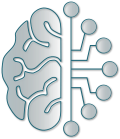

**Start at:** Thursday 20 June 2024, 13:57:05  
**Hostname:** insa-20188 (Windows)

<p style="text-align: center"><img width="800px" src="./styles/svg/pyNanoMatBuilder_banner.svg" style="margin-left:auto; margin-right:auto"/></p>

<module 'pyNanoMatBuilder.utils' from 'C:\\Users\\rollan\\Documents\\notebook\\pyNanoMatBuilder-main\\pyNanoMatBuilder-main\\pyNanoMatBuilder\\utils.py'>

In [69]:
##################
# Initialization #
##################

import os
import sys

print(os.getcwd())
cwd0 = './styles/'
sys.path.append(cwd0)

import visualID as vID
from visualID import  fg, hl, bg
vID.init(cwd0)

import numpy as np
import ase
from ase.io import write
from ase.visualize import view

import pyNanoMatBuilder.utils as pNMBu
import importlib
import pandas as pd

from pyNanoMatBuilder import platonicNPs as pNP

import importlib
importlib.reload(pNP)
importlib.reload(pNMBu)

## II) Définition des fonctions nécessaires à la creation du data frame 

### Définition de la fonction clean

**Cette fonction a pour but de supprimer la ligne en trop des fichiers xyz que on va creer** 

In [70]:
def clean_xyz(filename):
    dtype = {'names': ('element', 'x', 'y', 'z'),
             'formats': ('U2', float, float, float)}    
    element,x,y,z=np.loadtxt(filename,unpack=True,skiprows=2 , usecols=(0, 1, 2, 3), dtype=dtype)
    outfile=os.path.dirname(filename)+'/'+os.path.basename(filename).split('.')[0]+'.xyz'
    nb_atoms=len(x)
    line2write=str(nb_atoms)+'\n'
    line2write+='\n'
    for i in range(nb_atoms):
        line2write+=str(element[i])+'\t %.8f'%x[i] + '\t %.8f'%y[i] + '\t %.8f'%z[i] +'\n'
    with open(outfile,'w') as file:
        file.write(line2write)
    return outfile

### Définition de la fonction de gestion des datas frame pour la catégorie des solides platoniques

**Cette fonction a pour but de creer un data frame de une ligne contenant les arguments que on a donné**

In [71]:
def fonction_gestion_dataframe_shapes_platonic(element,forme,distance,couche):
    """
    forme (icosahedron , octahedron, dodecahedron , tetrahedron, cubefcc, cubebcc ) -- string
    element (ex Au )-- string
    distance = distance entre plus proche voisin -- float
    couche = nombre de couche pour former le solide , equivalent de taille -- integer
    
    """
    #on importe les bibliothèques utiles
    
    from pyNanoMatBuilder import crystalNPs as cyNP
  
    import numpy as np

    from pyNanoMatBuilder import platonicNPs as pNP

    import importlib
    

    # Création du DataFrame vide (que on viendra remplir dans la suite ) avec les colonnes spécifiées
    df = pd.DataFrame(columns=["Element", "Forme", "Distance","nbr_couche","q","Intensités"])

    #Disjonction de cas selon les arguments (plus précisément la forme) que ont a rentés
    if forme != "icosahedron" and forme != "octahedron" and forme != "dodecahedron" and forme != "tetrahedron" and forme != "cube" :
        print("La forme donnée n'est pas dans la classe des solides platonic")
              

    #cas pour l'icosahedron
    if forme == "icosahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        ico = pNP.regIco(f"{element}",distance,couche,aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write("stage/depotoire/tempo.xyz", ico.NP)
        
    #cas pour le tetrahedron  
    if forme == "tetrahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        Td = pNP.regfccTd(f"{element}",distance,couche,aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write("stage/depotoire/tempo.xyz", Td.NP)
       
    #cas pour le dodecahedron
    if forme == "dodecahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        rdd = pNP.regDD(f"{element}",distance,couche,aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write("stage/depotoire/tempo.xyz", rdd.NP)

    #cas pour l'octahedron
    if forme == "octahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction 
        fccOh = pNP.regfccOh(f"{element}",distance,couche,aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write("stage/depotoire/tempo.xyz",fccOh.NP)

    #cas pour le cube fcc
    if forme =="cubefcc":

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        fcc = pNP.cube('fcc',f"{element}",distance,couche,aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write("stage/depotoire/tempo.xyz", fcc.NP)

    #cas pour le cube bcc
    if forme =="cubebcc":

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        bcc = pNP.cube('bcc',f"{element}",distance,couche,aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write("stage/depotoire/tempo.xyz", bcc.NP)
        

    #On utilise la fonction Clean sur le fichier xyz que on vient de creer 
    xyz_file="stage/depotoire/tempo.xyz"
    xyz_file=clean_xyz(xyz_file)

    
    # On calcul I(q) avec la fonction debyecalculator et on rentre les tableau numpy générés dans les variable Q et I
    from debyecalculator import DebyeCalculator
    
    calc = DebyeCalculator(qmin=0.01,qmax=20,qstep=0.01,device='cpu',biso=0.01)
    Q, I = calc.iq(structure_source=xyz_file)

    ###### supression du fichier xyz pour garder seulement le nom
    os.remove("stage/depotoire/tempo.xyz")


    # On transforme nos deux tableau numpy Q et I en tableau et on rentrer nos arguments de fonction dans des variables
    Q=list(Q)
    Intensite=list(I)
    Distance =distance
    Couche=couche
    Element= f"{element}"
    Forme=f"{forme}"

    

    # On ajout une ligne au DataFrame (avec ce qu'on voulait dedans comme données) en utilisant loc
    df.loc[len(df)] = [Element, Forme, Distance, Couche, Q,Intensite]

    
    return df  

## III) Création du data frame 

**On utilise des boucles afin de parcourir toutes les formes, les éléments et le nombre de couche souhaitées.**
**On peut remarqué que à chaque élément il y a une seule distance associée, donc on ne parcours que les éléments dans la boucle**
**et on leurs associes leurs distance respective**

**Variables à changer pour les utilisateurs**

In [89]:
# Création de la liste des couches (à changer en fonction de ce que l'on veut)
couche = [10]

# Création de la liste des formes, avec liste_de_toutes_les_formes= ["icosahedron", "octahedron", "dodecahedron" , "tetrahedron", "cubefcc", "cubebcc"] 
forme= ["cubebcc"] #( à changer en fonction de ce que l'on veut (en prenant dans les elements de la liste_de_toutes_les_formes)

# Création des listes d'éléments (liste_element) et de distances (liste_distance
dtype={"names":("atom","distance"),"formats":('U2',float)} #juste pour avoir la liste des elements et des distances de dessous
liste_element,liste_distance=np.loadtxt("atom_latt2.txt",unpack=True,skiprows=1,usecols=[0,2],dtype=dtype)


# Création d'une variable nbr_elem pour parcourir la liste des éléments que de 0 à un certain nombre. 
# Si on veut parcourir toute la liste des éléments, nbr_elem =len(liste_element)
nbr_elem=4


# Nom du fichier de sortie 
fichier_sortie='stage/Base_de_données/cubebcc_nc10_4prem_elements.csv'

**On effectue la concaténation**

In [90]:
# Création du data frame vide (df_concatenated) que on va remplir au fur et à mesure
df_concatenated  = pd.DataFrame(columns=["Element", "Forme", "Distance","nbr_couche","q","Intensités"])


# On effectue donc les boucles imbriquées
for f in  forme :
    for s in couche:
        for i in range (0,nbr_elem): 
          

          # Création du data frame d'une ligne avec la fonction de gestion des datas frame , et contenant les éléments de la boucle en cours
          df_ligne = fonction_gestion_dataframe_shapes_platonic(liste_element[i],f,liste_distance[i],s)
          # Concaténation du data frame globale avec la data frame d'une ligne
          df_concatenated = pd.concat([df_concatenated , df_ligne])


        


# Sauvegarder le DataFrame en CSV avec tabulation
df_concatenated.to_csv(fichier_sortie, sep='\t', index=False)


La forme donnée n'est pas dans la classe des solides platonic
Now making a 10x10x10 fcc supercell...
... and adding the upper layers
Duration : 00:00:00 018ms


Moments of inertia = 184085270.91 184085270.91 184085270.91 amu.Å2
Moments of inertia / M = 347.85 347.85 347.85 amu.Å2
Size of the ellipsoid = 8.34 8.34 8.34 nm


Found:
  - 8 vertices
  - 12 simplices
Duration : 00:00:00 000ms


0 atoms lie in the plane(s)
Duration : 00:00:00 152ms
La forme donnée n'est pas dans la classe des solides platonic
Now making a 10x10x10 fcc supercell...
... and adding the upper layers
Duration : 00:00:00 020ms


C:\Users\rollan\AppData\Local\Temp\ipykernel_10148\1584392643.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concatenated = pd.concat([df_concatenated , df_ligne])


Moments of inertia = 51757269.24 51757269.24 51757269.24 amu.Å2
Moments of inertia / M = 205.84 205.84 205.84 amu.Å2
Size of the ellipsoid = 6.42 6.42 6.42 nm


Found:
  - 8 vertices
  - 12 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 120ms
La forme donnée n'est pas dans la classe des solides platonic
Now making a 10x10x10 fcc supercell...
... and adding the upper layers
Duration : 00:00:00 012ms


Moments of inertia = 12621310.72 12621310.72 12621310.72 amu.Å2
Moments of inertia / M = 200.68 200.68 200.68 amu.Å2
Size of the ellipsoid = 6.34 6.34 6.34 nm


Found:
  - 8 vertices
  - 12 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 140ms
La forme donnée n'est pas dans la classe des solides platonic
Now making a 10x10x10 fcc supercell...
... and adding the upper layers
Duration : 00:00:00 012ms


Moments of inertia = 167352183.25 167352183.25 167352183.25 amu.Å2
Moments of inertia / M = 295.37 295.37 295.37 amu.Å2
Size of the ellipsoid = 7.69 7.69 7.69 nm


Found:
  - 8 vertices
  - 12 simplices
Duration : 00:00:00 010ms


0 atoms lie in the plane(s)
Duration : 00:00:00 120ms


## IV) Affichage du Data frame creer

**On lit le fichier csv que on a enregistré plus haut et on l affiche**

In [91]:
# On rentre la lecture du fichier dans la variable data
data = pd.read_csv(fichier_sortie, sep='\t')

# On indexe la data frame comme il faut
data.index=np.arange(data.shape[0])

# On affiche le résultat final
data.shape
data

,Element,Forme,Distance,nbr_couche,q,Intensités
0,Ac,cubebcc,3.755444,10,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[42284544000.0, 40122420000.0, 36734450000.0, ..."
1,Ag,cubebcc,2.888885,10,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[11879734000.0, 11517107000.0, 10934350000.0, ..."
2,Al,cubebcc,2.852398,10,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[908874900.0, 881781700.0, 838205060.0, 780383..."
3,Am,cubebcc,3.460581,10,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[48300642000.0, 46196960000.0, 42869563000.0, ..."


## V) Vérification et analyse de nos données que l'on vient de creer

**Nous allons tracer les distribution des élements et des formes de notre data frame**

**                  Remarque : si on veut une base de données cohérente, il faut le meme nombre de forme en tout et le meme nombre d'éléments par forme également**

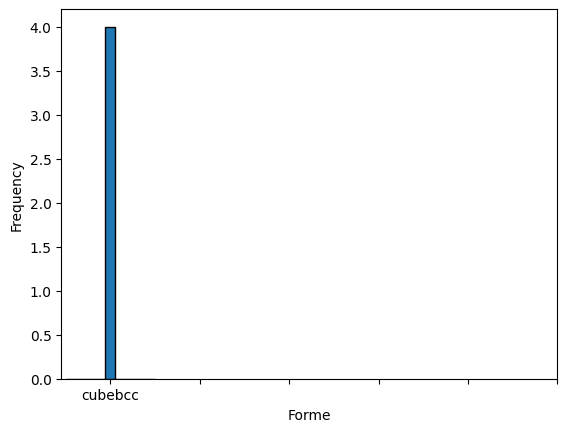

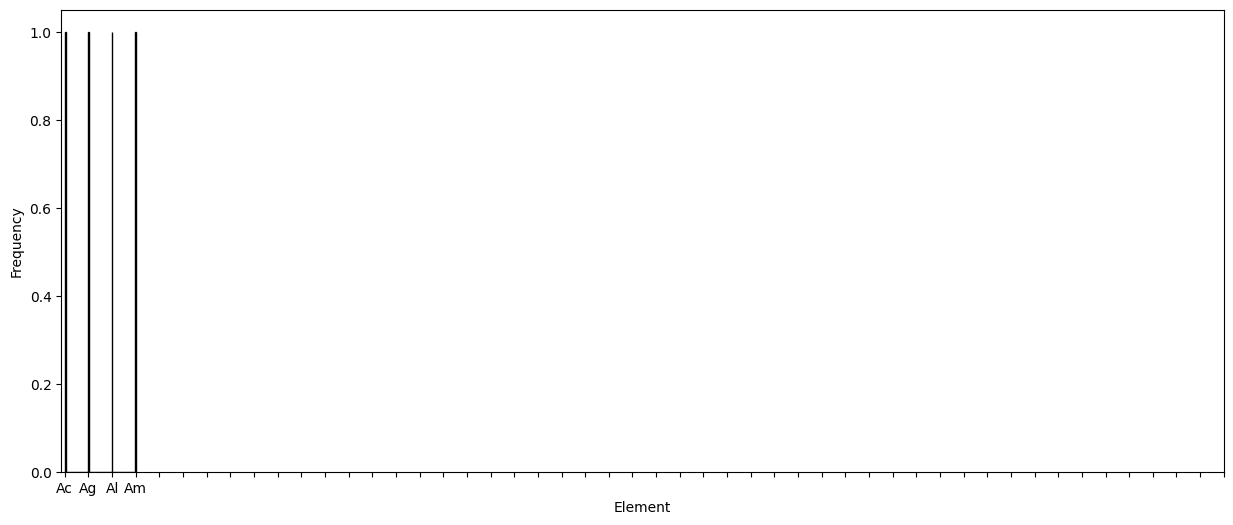

In [92]:

# On va creer un graph qui permet de forme la distribution des formes de notre data frame
import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots()

# Tracer l'histogramme
ax.hist(data['Forme'], bins=9,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Forme')
ax.set_ylabel('Frequency')

# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 6)  # Plage de 0 à 6
plt.xticks(x_ticks)

# Afficher la figure
plt.show()
#--------------------------------------------------------

# On va creer un graph qui permet de forme la distribution des éléments de notre data frame

import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15,6))


# Tracer l'histogramme
ax.hist(data['Element'], bins=100,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Element')
ax.set_ylabel('Frequency')


# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 50)  # Plage de 0 à 50
plt.xticks(x_ticks)


# Afficher la figure

plt.show()